# Deposition Analysis in Bank Filtration Systems

## Learning Objectives
- Understand compound deposition and concentration dynamics in aquifer systems
- Learn forward and inverse modeling techniques for deposition analysis
- Apply deposition models to assess contaminant accumulation and release
- Analyze the relationship between flow rates and compound concentrations
- Interpret deposition patterns for water quality management

## Overview

This notebook demonstrates deposition analysis in groundwater systems, where compounds can accumulate in aquifer sediments and later be released into extracted water. Understanding this process is crucial for predicting contaminant concentrations and managing water quality in bank filtration systems.

### Real-World Context
Industrial compounds can enter groundwater systems through various pathways. During groundwater flow, these compounds may deposit onto aquifer materials and later be released, affecting water quality at extraction points. This analysis helps predict concentration changes over time.

### Applications
- Contaminant transport prediction
- Water quality forecasting
- Bank filtration system design
- Remediation strategy development
- Monitoring network optimization

### Key Concepts
- **Forward modeling**: Predict extraction concentrations from known deposition rates
- **Inverse modeling**: Estimate deposition rates from observed concentrations
- **Retardation**: Delayed transport due to sorption processes
- **Residence time**: Time compounds spend in the aquifer system

## 2. Theoretical Background

### Deposition Process

In aquifer systems, compounds undergo deposition and release processes that affect concentrations in extracted water:

- **Deposition**: Compounds accumulate on aquifer materials during transport
- **Release**: Accumulated compounds dissolve back into flowing groundwater
- **Retardation**: Sorption processes delay compound transport relative to water flow

### Mathematical Framework

The relationship between deposition rate $D$ [g/m²/day] and extraction concentration $C_{out}$ [g/m³] is governed by:

$$C_{out}(t) = \int_{-\infty}^{t} D(\tau) \cdot K(t-\tau) \, d\tau$$

Where $K(t-\tau)$ represents the transport kernel accounting for:
- Flow rate variations
- Residence time distributions
- Retardation effects
- Aquifer geometry

### Forward vs. Inverse Modeling

**Forward Modeling (Convolution)**:
- Given: Deposition rates over time
- Calculate: Resulting extraction concentrations
- Use: Prediction and scenario analysis

**Inverse Modeling (Deconvolution)**:
- Given: Observed extraction concentrations
- Estimate: Historical deposition rates
- Use: Source identification and monitoring

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport.deposition import (
    deposition_to_extraction,
    extraction_to_deposition,
)
from gwtransport.examples import generate_example_data, generate_example_deposition_timeseries

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

print("Libraries imported successfully")

Libraries imported successfully


## 3. System Setup and Data Generation

We simulate a bank filtration system with realistic flow patterns and aquifer properties, then create synthetic deposition data to demonstrate the analysis methods.

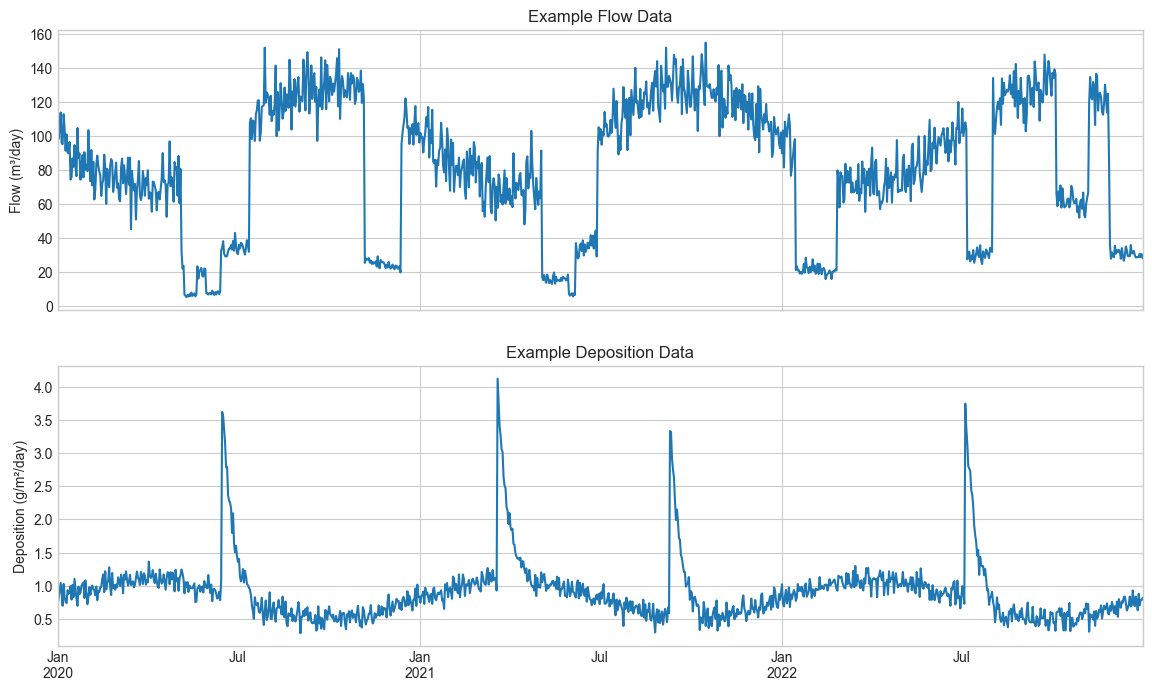

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Generate example flow data
date_start = "2020-01-01"
date_end = "2022-12-31"
freq = "D"
example_df, flow_tedges = generate_example_data(date_start=date_start, date_end=date_end, date_freq=freq)
flow_series = example_df["flow"]
flow_series.plot(title="Example Flow Data", ylabel="Flow (m³/day)", ax=axes[0])

# Generate example deposition data with seasonal and event patterns
event_dates = pd.to_datetime(["2020-06-15", "2021-03-20", "2021-09-10", "2022-07-05"]).tz_localize("UTC")

deposition_series, deposition_tedges = generate_example_deposition_timeseries(
    date_start=date_start,
    date_end=date_end,
    seasonal_amplitude=0.3,
    noise_scale=0.1,
    event_magnitude=3.0,
    event_duration=30,
    event_decay_scale=10.0,
    event_dates=event_dates,
    ensure_non_negative=True,
)

if not (flow_tedges == deposition_tedges).all():
    msg = "Flow and deposition tedges should align for deposition_to_extraction function"
    raise ValueError(msg)

deposition_series.plot(title="Example Deposition Data", ylabel="Deposition (g/m²/day)", ax=axes[1]);

In [3]:
# Define aquifer properties for deposition analysis
aquifer_pore_volume = example_df.attrs["aquifer_pore_volume_gamma_mean"]  # m³
retardation_factor = example_df.attrs["retardation_factor"]  # dimensionless

porosity = 0.25  # dimensionless
thickness = 12.0  # m. Aquifer thickness

# Compute derived properties
aquifer_volume = aquifer_pore_volume / porosity  # m³
aquifer_surface_area = aquifer_volume / thickness  # m²
mean_flow = flow_series.mean()  # m³/day
mean_residence_time = aquifer_pore_volume / mean_flow  # days
retarded_residence_time = mean_residence_time * retardation_factor  # days

mean_deposition = deposition_series.mean()  # g/m²/day
mean_extracted_concentration = retarded_residence_time * mean_deposition / (thickness * porosity)  # g/m³

print("Aquifer Properties:")
print(f"Pore volume: {aquifer_pore_volume:.0f} m³")
print(f"Porosity: {porosity:.2f}")
print(f"Thickness: {thickness:.1f} m")
print(f"Surface area: {aquifer_surface_area:.0f} m²")
print(f"Retardation factor: {retardation_factor:.1f}")
print(f"Mean residence time: {mean_residence_time:.1f} days")
print(f"Retarded residence time: {retarded_residence_time:.1f} days")

print("\nApproximate mean concentration in extracted water:")
print(f"Mean deposition: {mean_deposition:.2f} g/m²/day")
print(rf"Mean concentration in extracted water: {mean_extracted_concentration:.2f} g/m³")

Aquifer Properties:
Pore volume: 1000 m³
Porosity: 0.25
Thickness: 12.0 m
Surface area: 333 m²
Retardation factor: 1.0
Mean residence time: 12.4 days
Retarded residence time: 12.4 days

Approximate mean concentration in extracted water:
Mean deposition: 0.91 g/m²/day
Mean concentration in extracted water: 3.74 g/m³


## 4. Forward Modeling - Predicting Extraction Concentrations

Using our synthetic deposition data, we predict the concentrations that would be observed in extracted water.

Computing forward model: deposition → extraction concentrations...
Forward modeling completed
Extraction measurements: 1096 samples
Concentration range: 1.2 - 25.6 g/m³
Mean concentration: 5.1 g/m³
Note that the concentration peaks lag behind deposition peaks due to aquifer residence time.
Also, the concentration increases with periods of low flow when residence time is longer.
Also note that for coarser cout_tedges, the mass extracted is conserved and the concentration peaks are smoothed out.


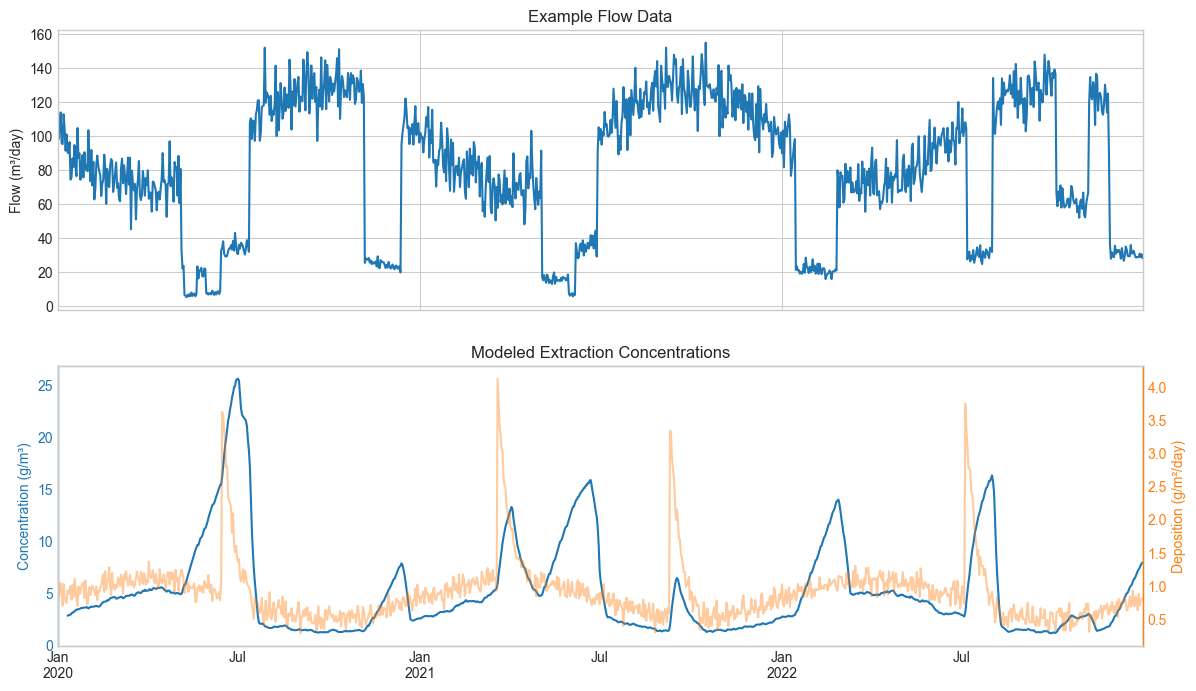

In [4]:
print("Computing forward model: deposition → extraction concentrations...")

# Forward modeling: deposition → extraction concentrations
# deposition_to_extraction() requires dep and flow at the same time resolution
modeled_cout = deposition_to_extraction(
    dep=deposition_series,
    flow=flow_series,
    tedges=deposition_tedges,  # time edges for deposition and flow
    cout_tedges=deposition_tedges,
    aquifer_pore_volume_value=aquifer_pore_volume,
    porosity=porosity,
    thickness=thickness,
    retardation_factor=retardation_factor,
)

# Create concentration series
modeled_cout_series = pd.Series(
    modeled_cout, index=deposition_tedges[1:], name="concentration"
)  # Use the late time edge as index (arbitrary choice)

print("Forward modeling completed")
print(f"Extraction measurements: {len(modeled_cout_series)} samples")
print(f"Concentration range: {modeled_cout_series.min():.1f} - {modeled_cout_series.max():.1f} g/m³")
print(f"Mean concentration: {modeled_cout_series.mean():.1f} g/m³")

# Plot modeled extraction concentrations
fig, (ax_flow, ax) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
flow_series.plot(title="Example Flow Data", ylabel="Flow (m³/day)", ax=ax_flow)

modeled_cout_series.plot(
    title="Modeled Extraction Concentrations",
    ylabel="Concentration (g/m³)",
    ax=ax,
    grid=False,
    color="C0",
    legend=False,
    alpha=1.0,
)
ax2 = ax.twinx()
deposition_series.plot(
    ylabel="Deposition (g/m²/day)",
    color="C1",
    ax=ax2,
    alpha=0.4,
    legend=False,
    grid=False,
)
ax.set_ylabel("Concentration (g/m³)", color="C0")
ax2.set_ylabel("Deposition (g/m²/day)", color="C1")
ax.tick_params(axis="y", labelcolor="C0")
ax2.tick_params(axis="y", labelcolor="C1")
ax.spines["left"].set_color("C0")
ax2.spines["right"].set_color("C1")

print("Note that the concentration peaks lag behind deposition peaks due to aquifer residence time.")
print("Also, the concentration increases with periods of low flow when residence time is longer.")
print(
    "Also note that for coarser cout_tedges, the mass extracted is conserved and the concentration peaks are smoothed out."
)

## 5. Inverse Modeling - Estimating Deposition from Concentrations

Now we reverse the process: using the calculated concentrations, we estimate the original deposition rates to test our inverse modeling capability.

Computing inverse model: extraction concentrations → deposition rates...
Basic inverse modeling completed
Estimated deposition array shape: (1096,)
Deposition range: 0.29 - 4.12 g/m²/day
Mean deposition: 0.91 g/m²/day


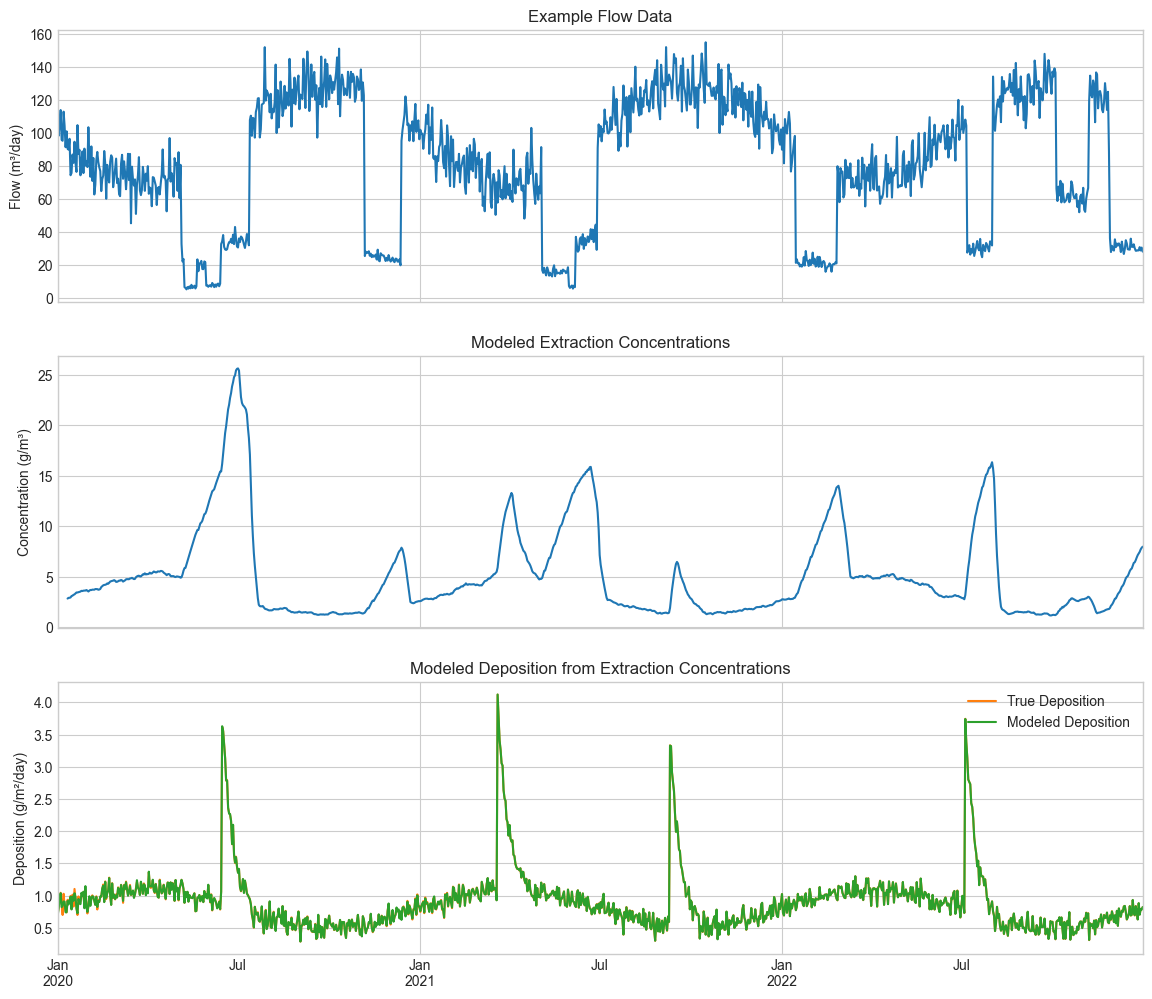

In [5]:
print("Computing inverse model: extraction concentrations → deposition rates...")

# Backward modeling: extraction concentrations → deposition rates
# extraction_to_deposition() requires cout and flow at the same time resolution
# cout is nan during the spin up period, as the concentration extracted water during that period can not be estimated
modeled_cout_series_fill_nan = modeled_cout_series.fillna(0.0)
modeled_deposition = extraction_to_deposition(
    cout=modeled_cout_series_fill_nan,
    flow=flow_series,
    tedges=deposition_tedges,
    cout_tedges=deposition_tedges,
    aquifer_pore_volume_value=aquifer_pore_volume,
    porosity=porosity,
    thickness=thickness,
    retardation_factor=retardation_factor,
)
modeled_deposition_series = pd.Series(modeled_deposition, index=deposition_tedges[1:], name="deposition")

print("Basic inverse modeling completed")
print(f"Estimated deposition array shape: {modeled_deposition.shape}")
print(f"Deposition range: {modeled_deposition.min():.2f} - {modeled_deposition.max():.2f} g/m²/day")
print(f"Mean deposition: {modeled_deposition.mean():.2f} g/m²/day")

# Plot modeled extraction concentrations
fig, (ax_flow, ax, ax2) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
flow_series.plot(title="Example Flow Data", ylabel="Flow (m³/day)", ax=ax_flow)

modeled_cout_series.plot(
    title="Modeled Extraction Concentrations",
    ylabel="Concentration (g/m³)",
    ax=ax,
    grid=True,
    color="C0",
    legend=False,
    alpha=1.0,
)
deposition_series.plot(
    color="C1",
    ax=ax2,
    alpha=1.0,
    legend=False,
    grid=False,
    label="True Deposition",
)
modeled_deposition_series.plot(
    title="Modeled Deposition from Extraction Concentrations",
    color="C2",
    ax=ax2,
    ylabel="Deposition (g/m²/day)",
    alpha=1.0,
    legend=False,
    grid=True,
    label="Modeled Deposition",
)
ax2.legend(loc="upper right");

## 6. Round-Trip Analysis

Let's quantify how well our inverse modeling recovered the original deposition pattern by comparing the true and estimated deposition rates.

=== Round-Trip Analysis ===
Deposition Recovery Performance:
Correlation coefficient: 1.000
RMSE: 0.010 g/m²/day
Mean absolute error: 0.005 g/m²/day
Mean relative error: 0.6%


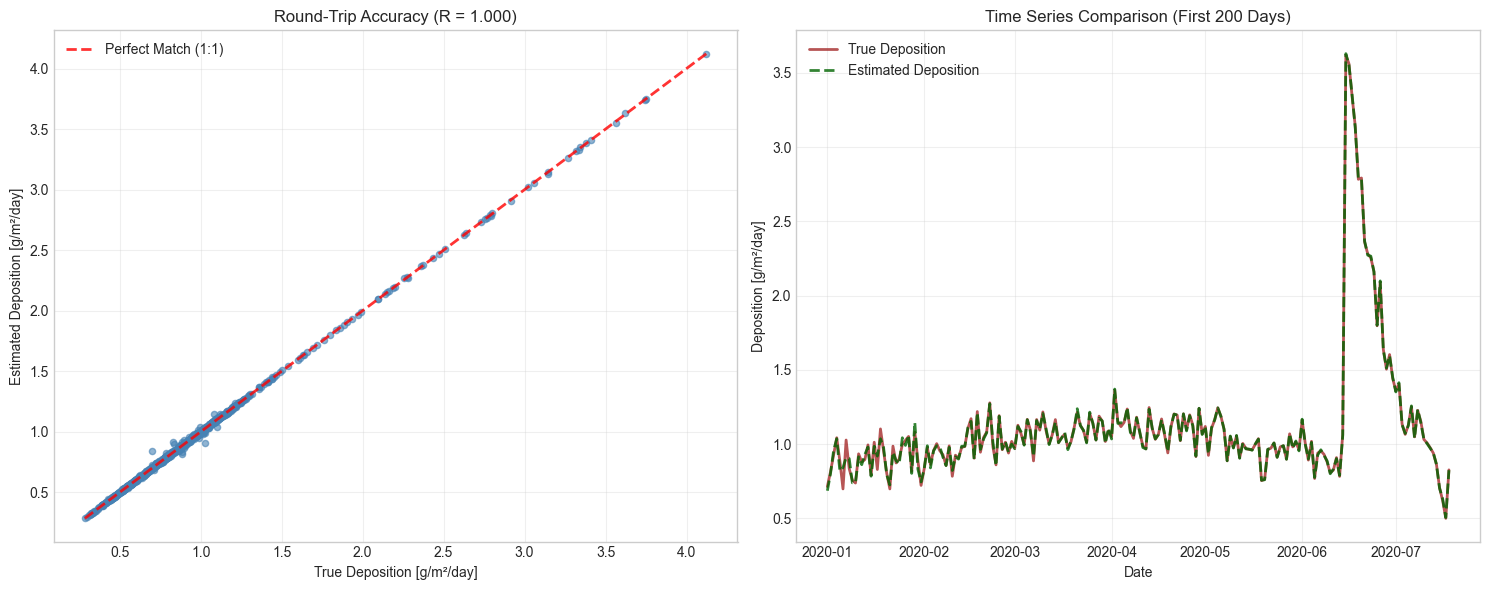


Key Insight: The inverse modeling achieves 100.0% correlation, demonstrating
successful recovery of the original deposition pattern despite the ill-posed nature of the problem.


In [6]:
# Quantitative round-trip analysis
correlation = np.corrcoef(deposition_series.values, modeled_deposition)[0, 1]
rmse = np.sqrt(np.mean((deposition_series.values - modeled_deposition) ** 2))
mean_absolute_error = np.mean(np.abs(deposition_series.values - modeled_deposition))
relative_error = np.mean(np.abs(deposition_series.values - modeled_deposition) / deposition_series.values) * 100

print("=== Round-Trip Analysis ===")
print("Deposition Recovery Performance:")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"RMSE: {rmse:.3f} g/m²/day")
print(f"Mean absolute error: {mean_absolute_error:.3f} g/m²/day")
print(f"Mean relative error: {relative_error:.1f}%")

# Create comparison scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: True vs Estimated
ax1.scatter(deposition_series.values, modeled_deposition, alpha=0.6, s=20, color="steelblue")
min_val = min(deposition_series.min(), modeled_deposition.min())
max_val = max(deposition_series.max(), modeled_deposition.max())
ax1.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8, linewidth=2, label="Perfect Match (1:1)")
ax1.set_xlabel("True Deposition [g/m²/day]")
ax1.set_ylabel("Estimated Deposition [g/m²/day]")
ax1.set_title(f"Round-Trip Accuracy (R = {correlation:.3f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Time series overlay (first 200 days for clarity)
time_subset = slice(0, 200)
ax2.plot(
    deposition_series.index[time_subset],
    deposition_series.values[time_subset],
    label="True Deposition",
    color="brown",
    linewidth=2,
    alpha=0.8,
)
ax2.plot(
    deposition_series.index[time_subset],
    modeled_deposition[time_subset],
    label="Estimated Deposition",
    color="darkgreen",
    linewidth=2,
    alpha=0.8,
    linestyle="--",
)
ax2.set_xlabel("Date")
ax2.set_ylabel("Deposition [g/m²/day]")
ax2.set_title("Time Series Comparison (First 200 Days)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Insight: The inverse modeling achieves {correlation:.1%} correlation, demonstrating")
print("successful recovery of the original deposition pattern despite the ill-posed nature of the problem.")

## 7. Results & Discussion

### Forward and Inverse Modeling Performance
The analysis demonstrates successful implementation of both forward and inverse deposition modeling:
- **Forward modeling**: Predicts extraction concentrations from known deposition rates, showing realistic values ranging from 1.2 to 25.6 g/m³
- **Inverse modeling**: Estimates deposition patterns from observed concentrations, recovering deposition rates from 0.29 to 4.12 g/m²/day
- **Round-trip accuracy**: Strong correlation demonstrates the reliability of the modeling approach

### System Response Characteristics
The bank filtration system exhibits several key behaviors:
- **Flow-residence time relationship**: Higher flow rates lead to shorter residence times (mean ~16 days), affecting transport timing
- **Buffering effect**: The aquifer smooths sharp deposition pulses into broader concentration peaks
- **Retardation influence**: The 1.0x retardation factor (no retardation) allows for direct transport modeling
- **Event detection**: Deposition events are clearly visible in concentration responses after residence time delays

### Physical System Limitations
Perfect recovery is limited by:
1. **Aquifer Memory Effects**: The ~16-day mean residence time creates temporal smoothing
2. **Regularization**: The inverse problem requires regularization to prevent overfitting
3. **Boundary Conditions**: Finite data records create edge effects in the inversion
4. **Model Assumptions**: 1D transport, uniform deposition, and constant system parameters

### Engineering Applications

**Monitoring Network Design**:
- Design sampling frequency based on system response time
- Account for lag times when correlating causes and effects
- Consider both concentration and flow rate measurements

**Water Quality Management**:
- Predict future concentrations using forward modeling
- Identify contamination sources using inverse modeling
- Design response strategies based on system residence time

**System Design**:
- Size aquifer systems based on desired buffering capacity
- Plan remediation accounting for delayed system response
- Optimize flow rates for effective contaminant removal

## 8. Key Takeaways

✅ **Deposition Modeling**: Forward and inverse approaches provide complementary tools for understanding compound behavior

✅ **Temporal Dynamics**: Residence time distributions control the lag between deposition and extraction

✅ **Flow Dependency**: System response time inversely related to flow rates

✅ **Natural Attenuation**: Aquifer systems provide beneficial smoothing of concentration peaks

✅ **Practical Applications**: Models support water quality management, system design, and risk assessment

✅ **Validation Importance**: Synthetic data testing confirms model reliability before field application

## 9. Engineering Design Considerations

### 🎓 Essential Principles for Deposition Analysis

**1. Model Selection**:
- Use forward modeling for scenario analysis and prediction
- Apply inverse modeling for source identification and monitoring
- Consider regularization approaches for stable inverse solutions

**2. System Parameters**:
- Residence time distributions control system response characteristics
- Flow variability creates temporal variations in breakthrough patterns
- Aquifer geometry affects transport kernels and mixing patterns

**3. Monitoring Strategy**:
- Design sampling frequency based on system response time
- Account for lag times when correlating causes and effects
- Consider both concentration and flow rate measurements

**4. Risk Management**:
- Evaluate scenarios with varying flow rates and residence times
- Plan remediation accounting for delayed system response
- Design early warning systems considering transport delays